# Métricas de evaluación de calidad de la imagen generada

## Importación librerías

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import Resize
from torch.cuda.amp import GradScaler, autocast
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm
from torchvision.models import ResNet50_Weights, Inception_V3_Weights
from torchvision import models

from monai import transforms
from monai.data import CacheDataset, DataLoader
from monai.utils import set_determinism

from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler
from generative.metrics import FIDMetric, MultiScaleSSIMMetric, SSIMMetric

## Carga de los imágenes reales

In [2]:
IMAGE_SIZE = 128

In [3]:
# data_dir = '/Users/alzorrcarri/Library/CloudStorage/Dropbox/MICCAI/complete_mednode_dataset'
data_dir = r"D:\alzor\Documents\Dropbox\MICCAI\complete_mednode_dataset"
melanoma_dir = data_dir + '/melanoma'
# naevus_dir = data_dir + '/naevus'

In [4]:
set_determinism(seed = 0)

In [5]:
# Obtenemos los nombres de los ficheros en los directorios de melanoma y naevus
melanoma_files = [os.path.join(melanoma_dir, x) for x in os.listdir(melanoma_dir)]
# naevus_files = [os.path.join(naevus_dir, x) for x in os.listdir(naevus_dir)]

In [6]:
melanoma_files[0]

'D:\\alzor\\Documents\\Dropbox\\MICCAI\\complete_mednode_dataset/melanoma\\136733.jpg'

In [7]:
# Cargamos las imágenes jpg de melanoma y naevus en un tensor de Pytorch
melanoma_images = []
# naevus_images = []
for image in melanoma_files:
    melanoma_images.append(plt.imread(image))
# for image in naevus_files:
#     naevus_images.append(plt.imread(image))

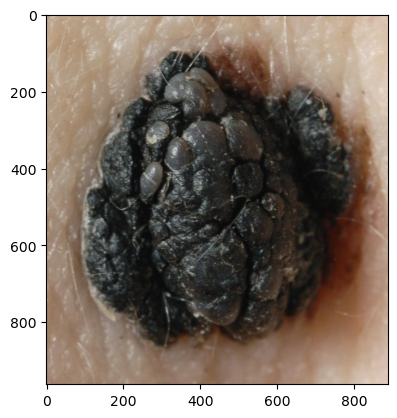

In [8]:
plt.imshow(melanoma_images[0])

In [9]:
type(melanoma_images[0])

numpy.ndarray

In [10]:
# Transformamos las imágenes a tensores de Pytorch
melanoma_tensors = []
# naevus_tensors = []
for image in melanoma_images:
    melanoma_tensors.append(torch.tensor(image))
# for image in naevus_images:
#     naevus_tensors.append(torch.tensor(image))

In [11]:
melanoma_tensors[0].shape

torch.Size([962, 888, 3])

In [12]:
# Intercambiamos los ejes de las imágenes para que tengan el formato correcto
melanoma_tensors = [torch.transpose(image, 0, 2) for image in melanoma_tensors]
# naevus_tensors = [torch.transpose(image, 0, 2) for image in naevus_tensors]

In [13]:
melanoma_tensors[0].shape

torch.Size([3, 888, 962])

In [14]:
# Redimensionamos las imágenes a otro tamaño
resize = Resize((IMAGE_SIZE, IMAGE_SIZE))
melanoma_tensors_resized = []
# naevus_tensors_resized = []
for image in melanoma_tensors:
    melanoma_tensors_resized.append(resize(image))
# for image in naevus_tensors:
#     naevus_tensors_resized.append(resize(image))

In [15]:
melanoma_tensors_resized[0].shape

torch.Size([3, 128, 128])

In [16]:
len(melanoma_tensors_resized)

70

In [17]:
# Convertimos las listas de imágenes en tensores de Pytorch
melanoma_Tensor = torch.stack(melanoma_tensors_resized)
# naevus_Tensor = torch.stack(naevus_tensors_resized)

# Normalizamos los tensores al rango [0,1]
melanoma_Tensor = melanoma_Tensor / 255
# naevus_Tensor = naevus_Tensor / 255

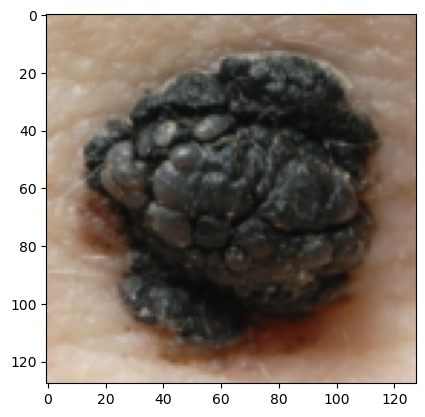

In [18]:
# Mostrar una imagen de melanoma
plt.imshow(melanoma_Tensor[0].permute(1, 2, 0))

In [19]:
dataset = CacheDataset(data = melanoma_Tensor, transform = transforms.ToTensor())

Loading dataset: 100%|██████████| 70/70 [00:00<00:00, 3388.05it/s]


In [20]:
# Creamos un DataLoader de Pytorch con el dataset
data_loader = DataLoader(dataset, batch_size = 2, shuffle = True)

## Carga del modelo generativo entrenado y sampleo de imágenes

In [21]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=3,
    num_channels=(256, 256, 256),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=256,
)
model.to(device)

scheduler = DDPMScheduler(num_train_timesteps=1000)
inferer = DiffusionInferer(scheduler)

In [22]:
# model.load_state_dict(torch.load("/Users/alzorrcarri/Library/CloudStorage/Dropbox/MICCAI/results/ddpm2d_skin_model.pt", map_location=device))
model.load_state_dict(torch.load(r"D:\alzor\Documents\Dropbox\MICCAI\results\ddpm2d_skin_model.pt", map_location=device))

<All keys matched successfully>

In [23]:
model.eval()
generated_images = []
for i in range(14):
    n_synthetic_images = 5
    noise = torch.randn((n_synthetic_images, 3, IMAGE_SIZE, IMAGE_SIZE))
    noise = noise.to(device)
    scheduler.set_timesteps(num_inference_steps=1000)
    with autocast(enabled=True):
        syn_images = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)
    generated_images.append(syn_images)

100%|██████████| 1000/1000 [33:13<00:00,  1.99s/it]


In [24]:
syn_images = torch.cat(generated_images, dim=0)

In [25]:
syn_images.shape

torch.Size([70, 3, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


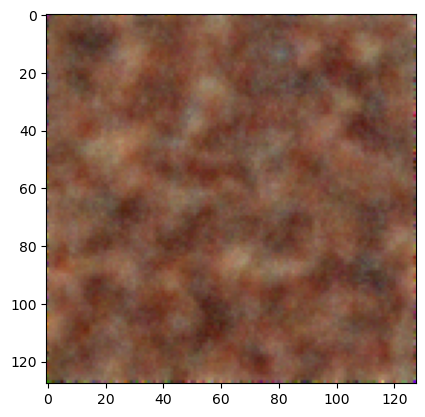

In [26]:
plt.imshow(syn_images[0].cpu().permute(1, 2, 0))

In [ ]:
# Ploteamos
for i, image in enumerate(syn_images):
    plt.figure(figsize=(2, 2))
    plt.imshow(image.cpu().permute(1, 2, 0))
    plt.tight_layout()
    plt.axis("off")
    # plt.savefig("/Users/alzorrcarri/Library/CloudStorage/Dropbox/MICCAI/generated_images/syn_image" + str(i) + ".png")
    plt.savefig(r"D:\alzor\Documents\Dropbox\MICCAI\generated_images\syn_image" + str(i) + ".png")

## Cálculo del SSIM para las imágenes generadas

In [28]:
from itertools import combinations

ms_ssim_scores = [] # Para almacenar los valores de MS-SSIM y SSIM entre las imágenes generadas
ssim_scores = []

ms_ssim = MultiScaleSSIMMetric(spatial_dims=2, data_range=1.0, kernel_size=2)
ssim = SSIMMetric(spatial_dims=2, data_range=1.0, kernel_size=2)

# Se calculan las métricas de calidad entre todas las combinaciones posibles de pares de imágenes generadas
idx_pairs = list(combinations(range(n_synthetic_images), 2))
for idx_a, idx_b in idx_pairs:
    ms_ssim_scores.append(ms_ssim(syn_images[[idx_a]], syn_images[[idx_b]]))
    ssim_scores.append(ssim(syn_images[[idx_a]], syn_images[[idx_b]]))

ms_ssim_scores = torch.cat(ms_ssim_scores, dim=0)
ssim_scores = torch.cat(ssim_scores, dim=0)

# Mostramos la media y la desviación estándar de los valores de MS-SSIM y SSIM
print(f"MS-SSIM Metric: {ms_ssim_scores.mean():.4f} +- {ms_ssim_scores.std():.4f}")
print(f"SSIM Metric: {ssim_scores.mean():.4f} +- {ssim_scores.std():.4f}")

MS-SSIM Metric: 0.4491 +- 0.0283
SSIM Metric: 0.5279 +- 0.0053


## Cálculo del FID con SkinLesNet

In [29]:
class SkinLesNet_Original(nn.Module):
    def __init__(self, IMAGE_SIZE):
        super(SkinLesNet_Original, self).__init__()
        # 1st Convolutional Input Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 2nd Convolutional Input Layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # 3rd Convolutional Layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        
        # 4th Convolutional Layer
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        self.dropout1 = nn.Dropout(0.5)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * (IMAGE_SIZE // 16) * (IMAGE_SIZE // 16), 64)  # Adjusting for downsampling
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 2)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = self.dropout1(x)
        
        x = x.view(-1, 128 * (IMAGE_SIZE // 16) * (IMAGE_SIZE // 16))  # Flatten the tensor
        
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.softmax(self.fc2(x), dim=1)
        
        return x
    
SLN_original = SkinLesNet_Original(IMAGE_SIZE)

In [30]:
# SLN_original.load_state_dict(torch.load("/Users/alzorrcarri/Library/CloudStorage/Dropbox/MICCAI/results/skinlesnet_trained.pth", map_location=device))
SLN_original.load_state_dict(torch.load(r"D:\alzor\Documents\Dropbox\MICCAI\results\skinlesnet_trained.pth", map_location=device))

<All keys matched successfully>

In [31]:
class SkinLesNet_FDI(nn.Module):
    def __init__(self, IMAGE_SIZE):
        super(SkinLesNet_FDI, self).__init__()
        # 1st Convolutional Input Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 2nd Convolutional Input Layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # 3rd Convolutional Layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        
        # 4th Convolutional Layer
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        self.dropout1 = nn.Dropout(0.5)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * (IMAGE_SIZE // 16) * (IMAGE_SIZE // 16), 64)  # Adjusting for downsampling
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = self.dropout1(x)
        
        x = x.view(-1, 128 * (IMAGE_SIZE // 16) * (IMAGE_SIZE // 16))  # Flatten the tensor
        
        x = F.relu(self.fc1(x))
        
        return x
    
SLN_FDI = SkinLesNet_FDI(IMAGE_SIZE)

In [32]:
SLN_FDI.conv1.weight.data = SLN_original.conv1.weight.data.clone()
SLN_FDI.conv1.bias.data = SLN_original.conv1.bias.data.clone()
SLN_FDI.pool = SLN_original.pool
SLN_FDI.conv2.weight.data = SLN_original.conv2.weight.data.clone()
SLN_FDI.conv2.bias.data = SLN_original.conv2.bias.data.clone()
SLN_FDI.conv3.weight.data = SLN_original.conv3.weight.data.clone()
SLN_FDI.conv3.bias.data = SLN_original.conv3.bias.data.clone()
SLN_FDI.conv4.weight.data = SLN_original.conv4.weight.data.clone()
SLN_FDI.conv4.bias.data = SLN_original.conv4.bias.data.clone()
SLN_FDI.dropout1 = SLN_original.dropout1
SLN_FDI.fc1.weight.data = SLN_original.fc1.weight.data.clone()
SLN_FDI.fc1.bias.data = SLN_original.fc1.bias.data.clone()

In [33]:
SLN_FDI.to(device)
SLN_FDI.eval()

SkinLesNet_FDI(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=8192, out_features=64, bias=True)
)

In [34]:
real_features = []
for step, batch in enumerate(data_loader):
    real_images = batch.to(device)
    real_features.append(SLN_FDI(real_images))


In [35]:
# Calculamos las características de la distribución de imágenes generadas
synth_features = []
synth_features.append(SLN_FDI(syn_images.to(device)))

In [36]:
synth_features = torch.vstack(synth_features).to(torch.device("cpu"))
real_features = torch.vstack(real_features).to(torch.device("cpu"))

fid = FIDMetric()
fid_res = fid(synth_features, real_features)

print(f"FID Score: {fid_res.item():.4f}")

FID Score: 23.6860


## Cálculo del FID con ResNet50

In [37]:
resnet50_model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

class ResNet_Original(nn.Module):
    def __init__(self, base_model):
        super(ResNet_Original, self).__init__()
        self.base_model = base_model
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1000, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.base_model(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.softmax(x, dim=1) # Añadir aux a la salida para el cálculo del FID

    def feature_size(self):
        return self.base_model.fc.in_features

ResNet50_Original = ResNet_Original(resnet50_model)

# ResNet50_Original.load_state_dict(torch.load("/Users/alzorrcarri/Library/CloudStorage/Dropbox/MICCAI/results/resnet50_retrained.pth", map_location=device))
ResNet50_Original.load_state_dict(torch.load(r"D:\alzor\Documents\Dropbox\MICCAI\results\resnet50_retrained.pth", map_location=device))

<All keys matched successfully>

In [38]:
class ResNet50_FDI(nn.Module):
    def __init__(self, base_model):
        super(ResNet50_FDI, self).__init__()
        self.base_model = base_model
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1000, 512)

    def forward(self, x):
        x = self.base_model(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        return x
    
ResNet50_FDI = ResNet50_FDI(resnet50_model)

ResNet50_FDI.fc1.weight.data = ResNet50_Original.fc1.weight.data.clone()
ResNet50_FDI.fc1.bias.data = ResNet50_Original.fc1.bias.data.clone()

ResNet50_FDI.to(device)
ResNet50_FDI.eval()

ResNet50_FDI(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [39]:
real_features = []
for step, batch in enumerate(data_loader):
    real_images = batch.to(device)
    real_features.append(ResNet50_FDI(real_images))

synth_features = []
synth_features.append(ResNet50_FDI(syn_images.to(device)))

synth_features = torch.vstack(synth_features).to(torch.device("cpu"))
real_features = torch.vstack(real_features).to(torch.device("cpu"))

fid = FIDMetric()
fid_res = fid(synth_features, real_features)

print(f"FID Score: {fid_res.item():.4f}")

FID Score: 30.0948


## Cálcuo del FID con InceptionV3

In [40]:
inceptionv3_model = models.inception_v3(weights=Inception_V3_Weights.DEFAULT)

class InceptionV3_Original(nn.Module):
    def __init__(self, base_model):
        super(InceptionV3_Original, self).__init__()
        self.base_model = base_model
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1000, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 2)

    def train(self, mode=True):
        super().train(mode)
        self.training = mode

    def eval(self):
        super().eval()

    def forward(self, x):
        if self.training:
            x, _ = self.base_model(x)
        else:
            x = self.base_model(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
Inception_V3_Original = InceptionV3_Original(inceptionv3_model)

# Inception_V3_Original.load_state_dict(torch.load("/Users/alzorrcarri/Library/CloudStorage/Dropbox/MICCAI/results/inceptionv3_retrained.pth", map_location=device))
Inception_V3_Original.load_state_dict(torch.load(r"D:\alzor\Documents\Dropbox\MICCAI\results\inceptionv3_retrained.pth", map_location=device))

<All keys matched successfully>

In [41]:
class InceptionV3_FDI(nn.Module):
    def __init__(self, base_model):
        super(InceptionV3_FDI, self).__init__()
        self.base_model = base_model
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1000, 512)

    def train(self, mode=True):
        super().train(mode)
        self.training = mode

    def eval(self):
        super().eval()

    def forward(self, x):
        if self.training:
            x, _ = self.base_model(x)
        else:
            x = self.base_model(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        return x
    
Inception_V3_FDI = InceptionV3_FDI(inceptionv3_model)

Inception_V3_FDI.fc1.weight.data = Inception_V3_Original.fc1.weight.data.clone()
Inception_V3_FDI.fc1.bias.data = Inception_V3_Original.fc1.bias.data.clone()

Inception_V3_FDI.to(device)
Inception_V3_FDI.eval()


In [42]:
real_features = []
for step, batch in enumerate(data_loader):
    real_images = batch.to(device)
    real_features.append(Inception_V3_FDI(real_images))

synth_features = []
synth_features.append(Inception_V3_FDI(syn_images.to(device)))

synth_features = torch.vstack(synth_features).to(torch.device("cpu"))
real_features = torch.vstack(real_features).to(torch.device("cpu"))

fid = FIDMetric()
fid_res = fid(synth_features, real_features)

print(f"FID Score: {fid_res.item():.4f}")

FID Score: 1264.9578
